- ref: https://github.com/kuangliu/pytorch-cifar
- ref: https://morvanzhou.github.io/tutorials/machine-learning/torch/4-05-DQN/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.losses import mean_squared_error as MSE
from keras.losses import categorical_crossentropy as NLL 
from time import time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


# Hyperparameter

In [2]:
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # Optimal action selection ratio
GAMMA = 0.9                 # Reward decay coefficient
TARGET_REPLACE_ITER = 100   # Q_target update frequency
MEMORY_CAPACITY = 300       # memory capacity
action_space = [ '+', '-' ]     # Just two action: go right and go left
N_ACTIONS = len(action_space)
state_space = [ s for s in range(0,10) ] # 10 states, from interger 0 to 10
N_STATES = len(state_space)

# Environment

create an environment, and assume it's unknown

In [3]:
class Environment(object):
    def __init__(self, ):
        self.argmin = 0
        while (self.argmin<=0 or self.argmin>=N_STATES-1):  #Avoid the boundary min.
            self.hidden_coeff = np.random.randint(N_STATES,2*N_STATES,2)
            self.model = self._build_model()
            self.arr = np.array([ self.model(x) for x in range(N_STATES) ])
            self.argmin = np.argmin(self.arr)
        self.min = np.min(self.arr).astype('float32')
        self.stop_condition = self.min + 0.001*np.abs(self.min)/float(N_STATES)
        print('build_model: hidden_coeff={}, argmin={}, min={}, stop_condition={} '.format(self.hidden_coeff,self.argmin, self.min, self.stop_condition))
        self.current_state = np.random.randint(0,N_STATES)
         
    def _build_model(self,):
        def fn(x):
            scale, bias = self.hidden_coeff
            op = np.sin(scale*float(x)*N_STATES + bias) 
            return op
        return fn
             
    def reset(self, ): 
        self.current_state = np.random.randint(0,N_STATES)
        print ('reset:  current_state={}'.format(self.current_state))
        return self.current_state
    
        
    def step(self, action): # define reward
        s = self.current_state
        y = self.model(s)
        if action == 0:
            s+= 1 # go to right
        else:
            s-= 1 # go to left
        self.current_state = s
        y_ = self.model(s)
        s_ = self.current_state
        r = (y-y_)
        boo_reach_min = (y <= self.stop_condition)
        boo_out_of_range = (s_ < 0 or s_>= N_STATES) # if out of range
        done = False
        if  boo_reach_min: 
            r *= 50
            done = True
        else:
            if boo_out_of_range:
                r *= 100 if r < 0 else -100
                done = True
        info = None
        print ('step: y={:.4f}, y_={:.4f}, next_state={}, reward={:.4f}, done={}'.format(y, y_, self.current_state,r,done))
        return s_, r, done, info
        

In [6]:
env= Environment() # retry until the evironment is satisfied 

build_model: hidden_coeff=[12 15], argmin=4, min=-0.980233669281, stop_condition=-0.980135645914 


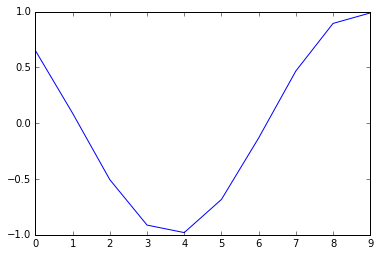

In [7]:
plt.plot(range(N_STATES), env.arr)

# Agent

In [8]:
class Net():
    def __init__(self, ):
        self.model = self.build_model( input_shape=(N_STATES,) )
        self.model.compile(optimizer=SGD(LR), loss=MSE)
        
    def build_model(self, input_shape):
        model = Sequential([
            Dense(N_STATES*2, input_shape=input_shape),
            Activation('relu'),
            Dense(N_ACTIONS),
        ])  
        #print(model.summary())
        return model
    
    def train(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def predict(self, x):
        return self.model.predict_on_batch(x)

    

net = Net()# for testing

In [9]:
class DQN(object):
    def __init__(self):
        self.target_net , self.eval_net = Net(),  Net() #A Target Net and an Eval Net.
        self.learn_step_counter = 0     # used when Q_target updates
        self.memory_counter = 0         # count current memory state 
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES*2+2))     # initialize memory 
        self.eval_loss_histroy = []

    def choose_action(self, x): # 'x' is a list, means state, e.g. [0,1,0,0,0,...,0]
        x = np.array([x]) # => 2-D array , here, we just input ONE sample
        s = np.argmax(x)  # a scalar
        if np.random.uniform() < EPSILON:   # if choose the optimal action
            actions_value = self.eval_net.predict(x)
            action = np.argmax(actions_value)  # return the argmax
            print('choose_action: {} from state {}'.format(action, s))
        else:   # if choose a random action
            action = np.random.randint(0, N_ACTIONS)
            print('choose_action: {} randomly from state {}'.format(action, s))
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # if memory is full, rewrite the old data
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target net update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.model.set_weights(self.eval_net.model.get_weights())
        self.learn_step_counter += 1
        self.memory_counter = 0

        # extract batch data from memory
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = b_memory[:, :N_STATES]                         # shape (BATCH_SIZE, N_STATES)
        b_a = b_memory[:, N_STATES:N_STATES+1].astype(int)   # shape (BATCH_SIZE, 1)
        b_r = b_memory[:, N_STATES+1:N_STATES+2]             # shape (BATCH_SIZE, 1)
        b_s_ = b_memory[:, -N_STATES:]                       # shape (BATCH_SIZE, N_STATES)
        assert b_s.shape == (BATCH_SIZE, N_STATES)
        assert b_a.shape == (BATCH_SIZE, 1)
        assert b_r.shape == (BATCH_SIZE, 1)
        assert b_s_.shape == (BATCH_SIZE, N_STATES)

        # q_eval has values of all actions, 
        # but we just take the values of action from vector b_a
        # replace them with the values of Q_target
        q_eval = self.eval_net.predict(b_s) # shape (BATCH_SIZE, N_ACTIONS)
        q_next = self.target_net.predict(b_s_)    # shape (BATCH_SIZE, N_ACTIONS), q_next 不进行反向传递误差
        assert q_eval.shape == (BATCH_SIZE, N_ACTIONS)
        assert q_next.shape == (BATCH_SIZE, N_ACTIONS)
        q_target = q_eval # shape (BATCH_SIZE, N_ACTIONS)
        max_ = np.expand_dims(np.max(q_next, axis=1),1)
        assert max_.shape == (BATCH_SIZE, 1)
        q_ = b_r + GAMMA * max_ 
        assert q_.shape == (BATCH_SIZE, 1)
        q_target[range(BATCH_SIZE),b_a] =  q_ # shape (BATCH_SIZE, 1)

        # update eval net
        loss = self.eval_net.train(b_s, q_target)
        self.eval_loss_histroy.append(loss)
        
    def plot_loss(self, ):
        print(self.eval_loss_histroy)
        plt.plot( range(len(self.eval_loss_histroy)) , self.eval_loss_histroy)
        plt.show()
        

dqn = DQN()       


episode: 0
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 1
reset:  current_state=1
choose_action: 0 randomly from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 randomly from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_act

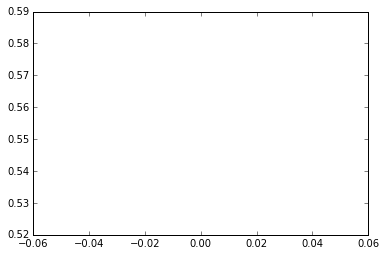

choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0

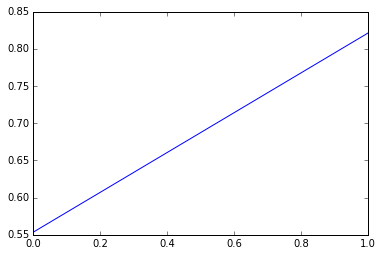

choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 randomly from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 19
reset:  current_state=4
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 20
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=Fal

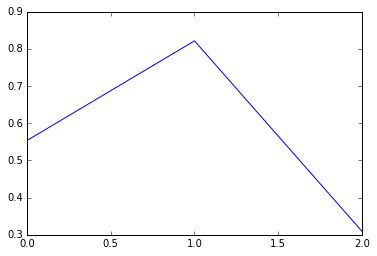

choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 

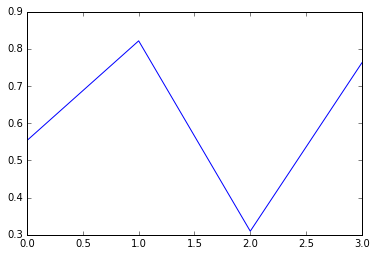

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from sta

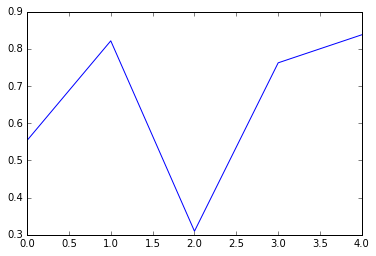

choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0

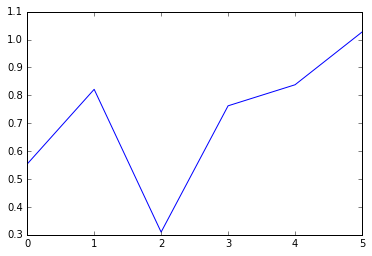

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 0 randomly from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 0 randomly from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
e

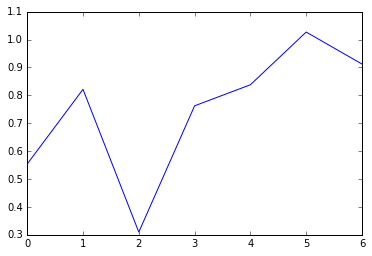

choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 0 randomly from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=Fal

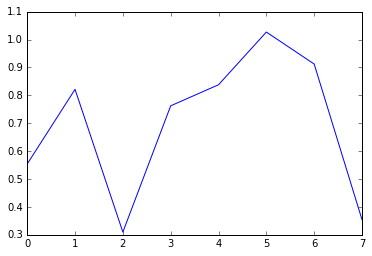

choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 

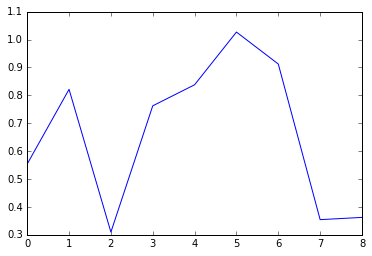

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 

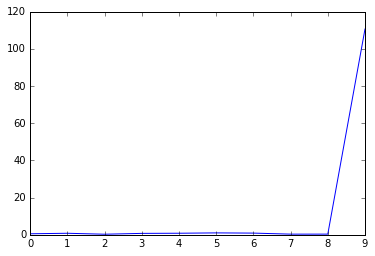

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 100
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 101
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 102
reset:  current_state=7
choose_action: 1 from state 7
step: 

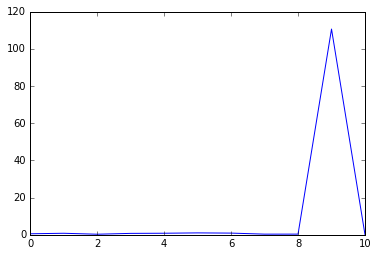

choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 200
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 randomly from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 randomly from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 201
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.

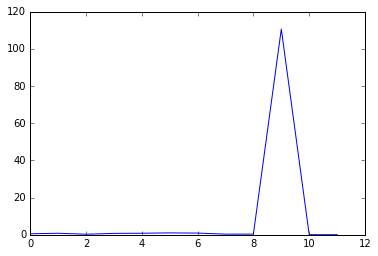

choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 299
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 0 randomly from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 300
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7,

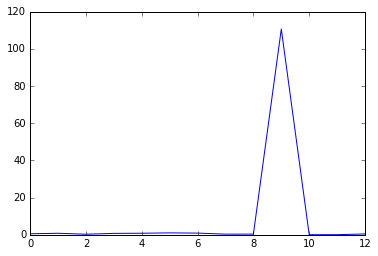

choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 389
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 390
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 391
reset:  current_state=3
choose_action: 1 randomly from state 3
step

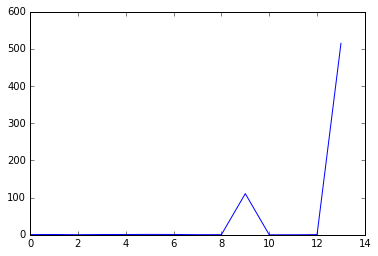

choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 485
reset:  current_state=3
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 486
reset:  current_state=7
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 randomly from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 487
reset:  current_state=6
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 randomly from stat

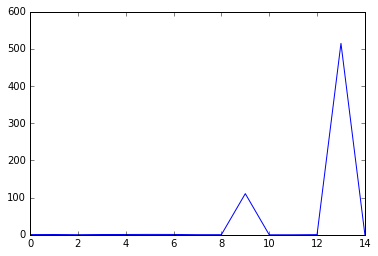

choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 

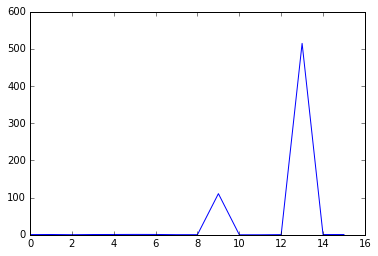

choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 

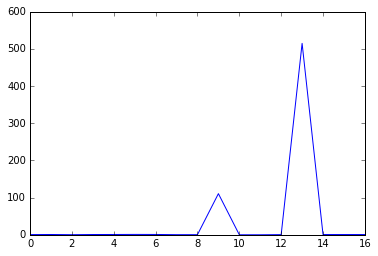

choose_action: 1 randomly from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose

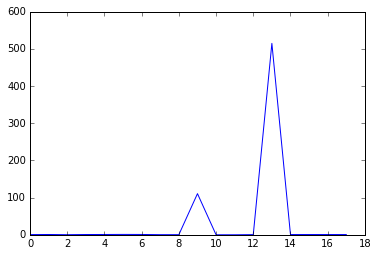

choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 

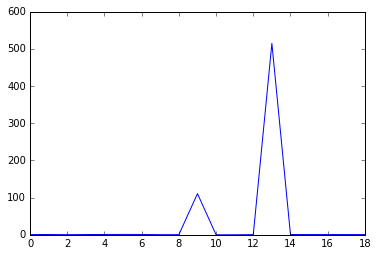

choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 580
reset:  current_state=7
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 581
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 582
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 583
reset:  current_state=3
choose_action: 1 randomly from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward

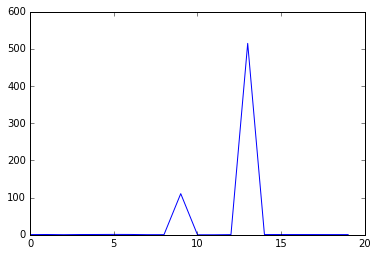

choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 594
reset:  current_state=7
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 595
reset:  current_state=0
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 randomly from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=

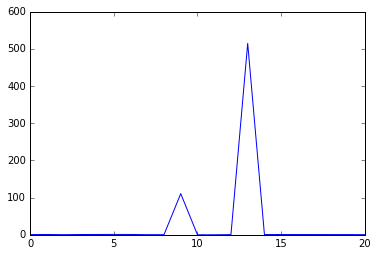

episode end at 9

episode: 685
reset:  current_state=7
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 686
reset:  current_state=8
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 687
reset:  current_state=5
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, 

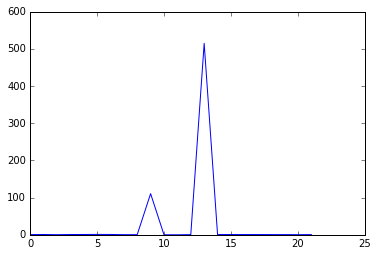

choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 1 randomly from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 706
reset:  current_state=7
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 randomly from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 707
reset:

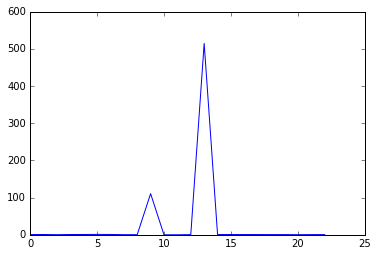

choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 793
reset:  current_state=2
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 794
reset:  current_state=1
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 795
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9

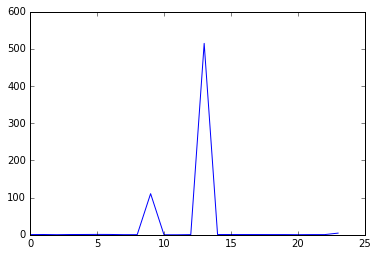

choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 894
reset:  current_state=4
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 895
reset:  current_state=0
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 896
reset:  current_state=6
choose_action: 0 from state 6
step: y=-0.13

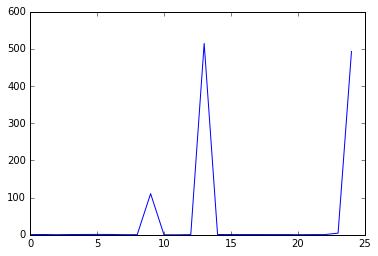

episode end at 9

episode: 988
reset:  current_state=6
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 989
reset:  current_state=2
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 990
reset:  current_state=3
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.980

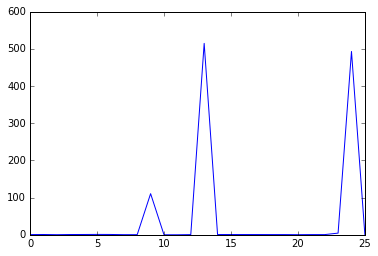

episode end at 9

episode: 1080
reset:  current_state=0
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 1081
reset:  current_state=2
choose_action: 0 from state 2
step: y=-0.5064, y_=-0.9130, next_state=3, reward=0.4066, done=False
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 0 from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 1082
reset:  current_state=1
choose_action: 0 from state 1
step: y=0.0

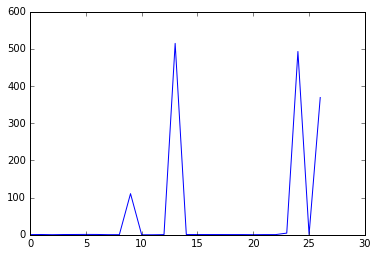

episode end at 9

episode: 1161
reset:  current_state=6
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 0 randomly from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 1162
reset:  current_state=7
choose_action: 0 from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 1 randomly from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 0 from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.32

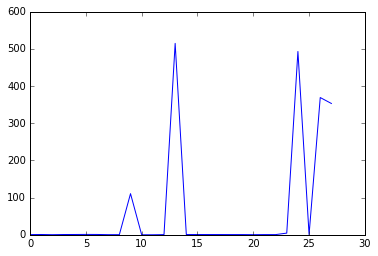

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 randomly from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_

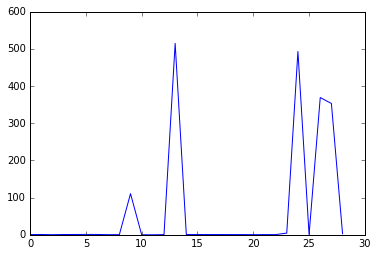

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_

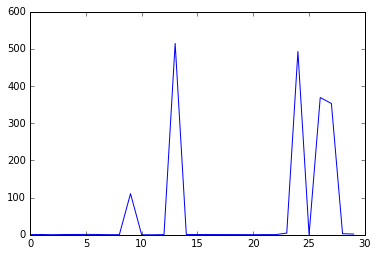

choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from sta

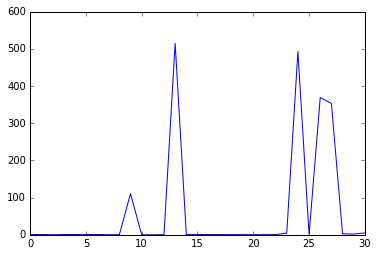

choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 

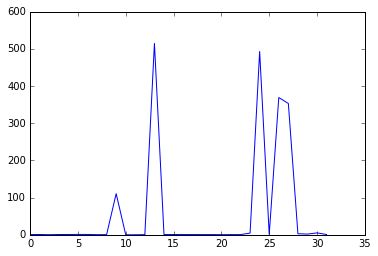

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 

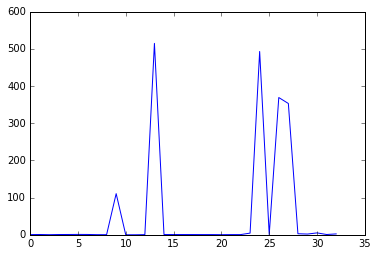

choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 

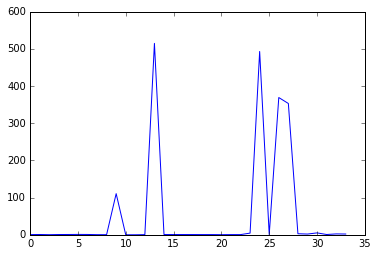

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True

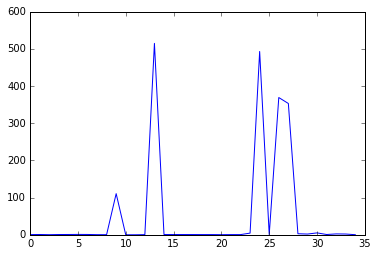

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from sta

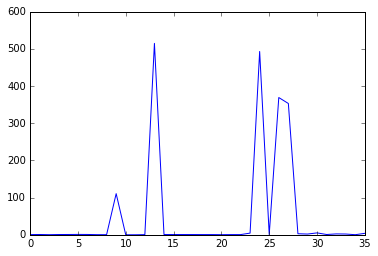

choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choos

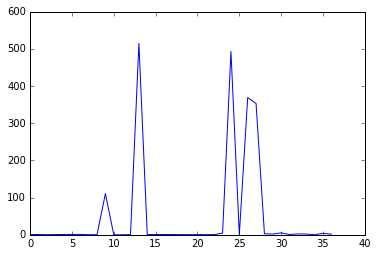

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=Fals

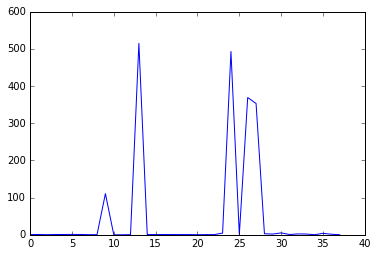

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=

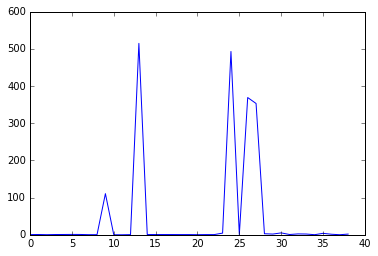

choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action

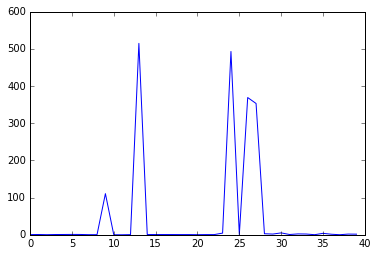

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choos

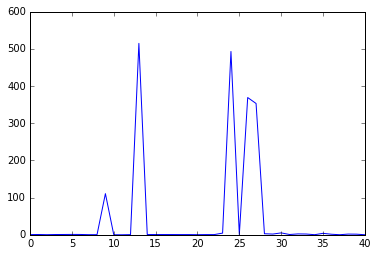

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 0 randomly from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 0 randomly from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
cho

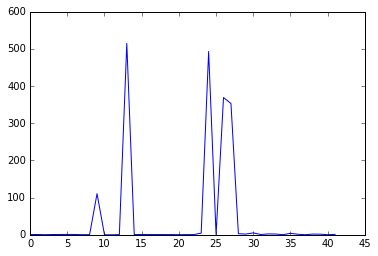

choose_action: 1 randomly from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1336
reset:  current_state=0
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884,

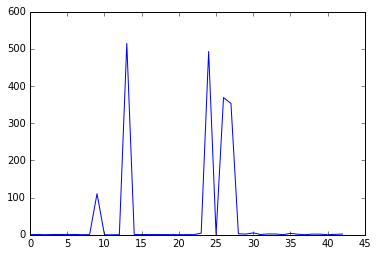

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False


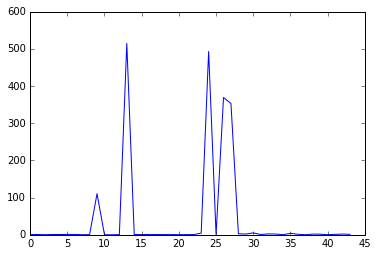

episode end at 0

episode: 1355
reset:  current_state=5
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1356
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3

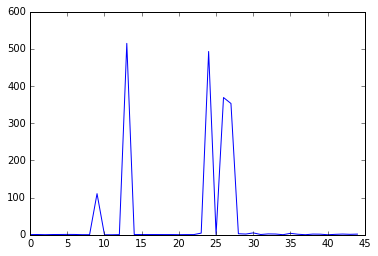

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 0 randomly from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 1369
reset:  current_state=7
choose_action: 1 randomly from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from st

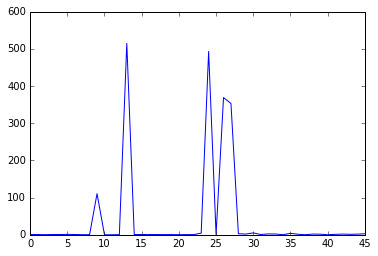

choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=Fa

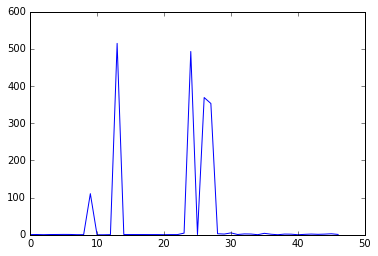

episode end at 4

episode: 1387
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 1388
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1389
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1390
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1391
reset:  current_state=3
choose_action: 0 from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1392
reset:  current_state=5
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=

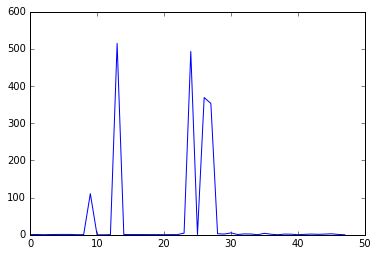

choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, rewa

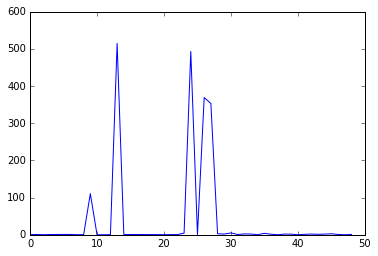

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=Fals

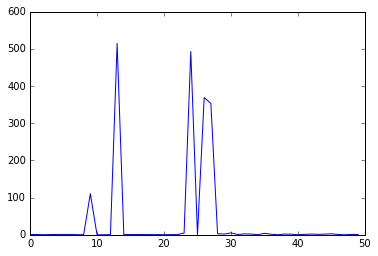

episode end at 9

episode: 1418
reset:  current_state=6
choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
ste

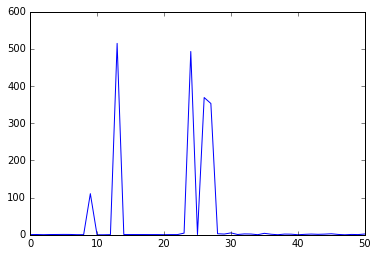

choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choos

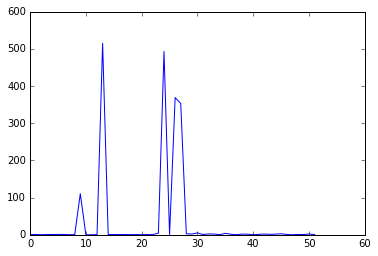

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 randomly from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1429
reset:  current_state=0
choose_action: 0 from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y

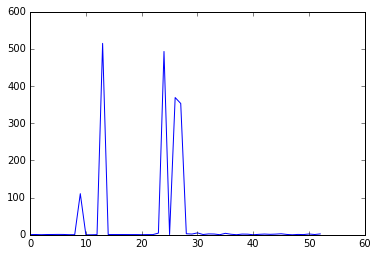

choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choos

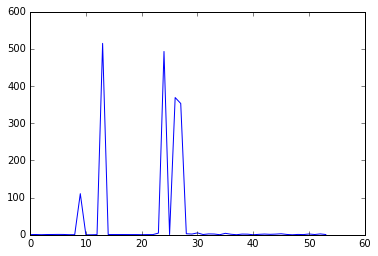

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1441
reset:  current_state=9
choose_action: 0 from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 1442
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1443
reset:  current_state=7
choose_action: 1 from state 7


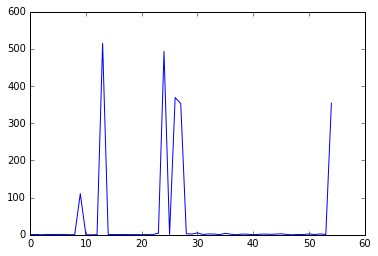

choose_action: 1 randomly from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1462
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1463
reset:  current_state=0
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1464
reset:  current_state=0
choose_action: 1 from sta

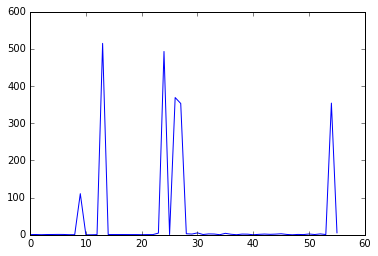

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1556
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1557
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1558
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
st

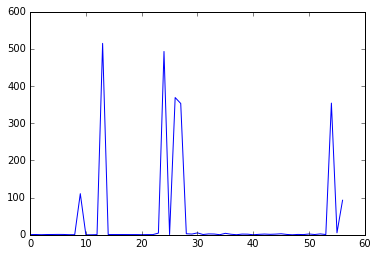

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1642
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1643
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1644
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1645
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.55

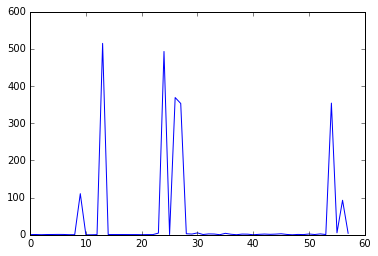

episode end at 0

episode: 1729
reset:  current_state=3
choose_action: 0 randomly from state 3
step: y=-0.9130, y_=-0.9802, next_state=4, reward=0.0673, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1730
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1731
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1732

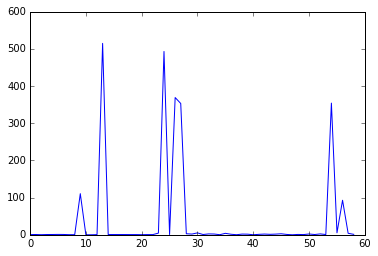

choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1821
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 0 randomly from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, reward=-14.8508, done=True
episode end at 4

episode: 1822
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, do

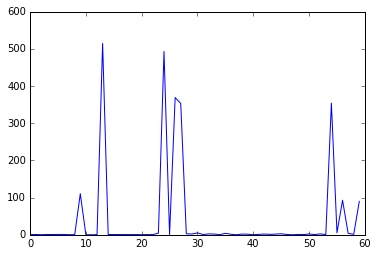

episode end at 4

episode: 1914
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 1915
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 1916
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884

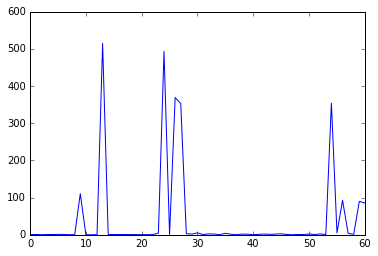

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2002
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2003
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2004
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.

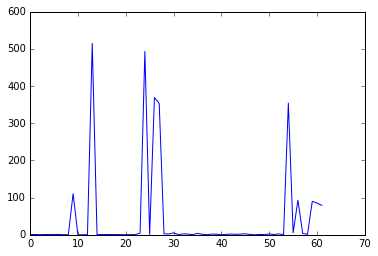

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2095
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2096
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2097
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2098
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0

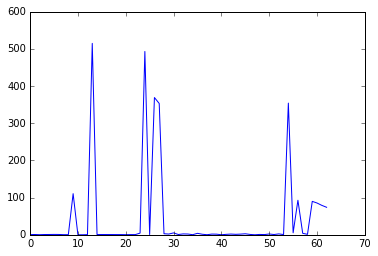

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2190
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2191
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
ch

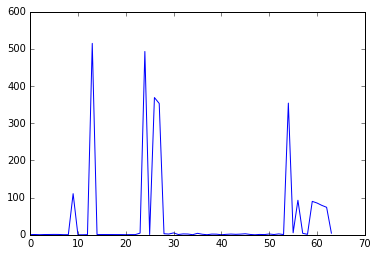

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2279
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2280
reset:  current_state=1
ch

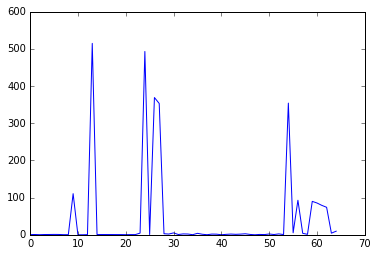

choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2369
reset:  current_state=9
choose_action: 1 randomly from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2370
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done

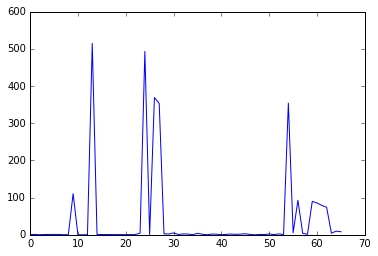

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2458
reset:  current_state=5
choose_action: 0 randomly from state 5
step: y=-0.6832, y_=-0.1323, next_state=6, reward=-0.5509, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2459
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2460
reset:  current_state=4
choose_action: 0 rand

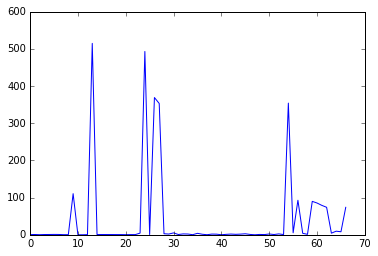

episode end at 4

episode: 2543
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2544
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 randomly from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2545
reset:  current_state=4
choose_action: 1 randomly from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2546
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2547
reset:  current_state=8
choose_act

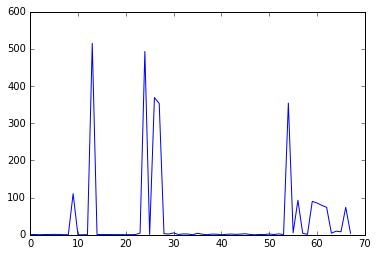

episode end at 0

episode: 2635
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2636
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
cho

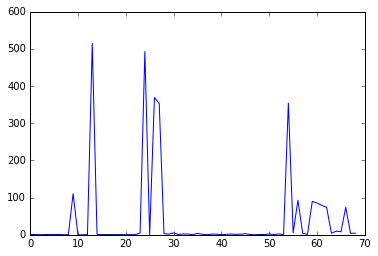

choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2737
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2738
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2739
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.

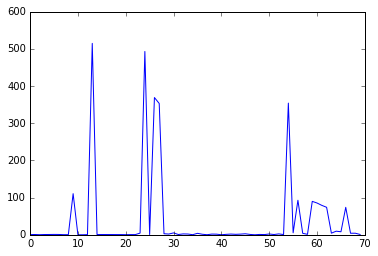

choose_action: 0 randomly from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 0 randomly from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 2838
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2839
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.550

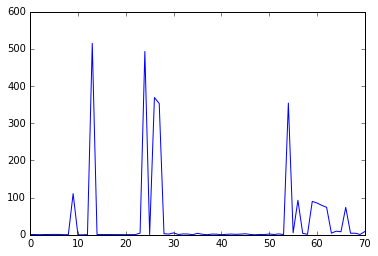

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2927
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2928
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 2929
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 2930
reset:  cu

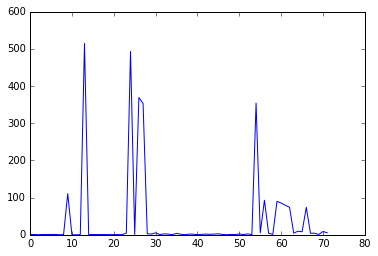

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3023
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3024
reset:  current_state=8
choose_action: 0 randomly from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=

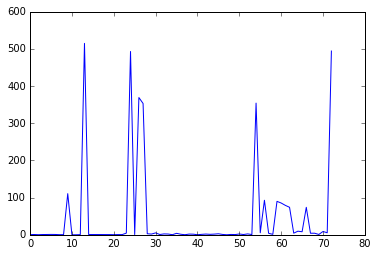

episode end at 0

episode: 3119
reset:  current_state=0
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3120
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3121
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3122
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3123
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 rand

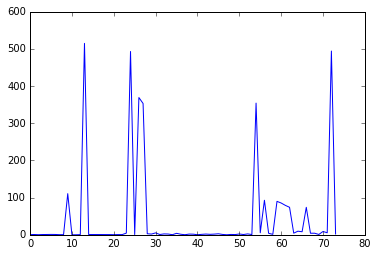

choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3210
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3211
reset:  current_state=9
choose_action: 1 randomly from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=

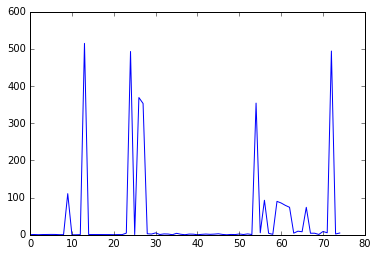

choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3294
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3295
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3296
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 0 randomly from state 2
s

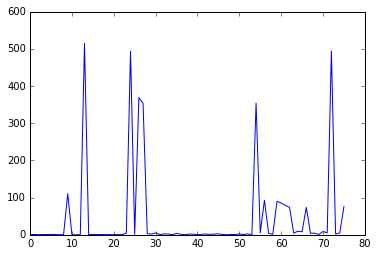

episode end at 0

episode: 3383
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3384
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3385
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3386
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.297

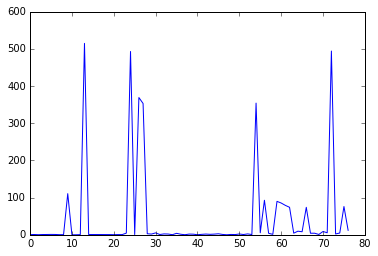

episode end at 4

episode: 3478
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3479
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=

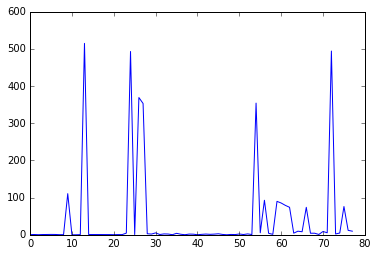

episode end at 4

episode: 3571
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3572
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3573
reset:  current_state=9
choose_action: 1 randomly from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 

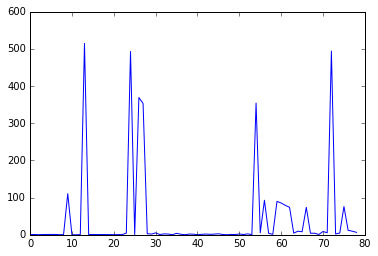

episode end at 4

episode: 3661
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3662
reset:  current_state=5
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3663
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
ste

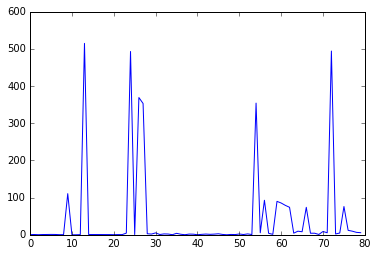

episode end at 4

episode: 3752
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3753
reset:  current_state=8
choose_action: 0 randomly from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 1 randomly from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3754
reset:  current_state=0
choose_action: 1 from state 

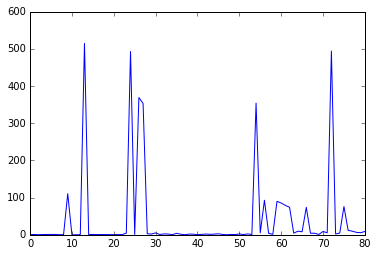

episode end at 4

episode: 3843
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 randomly from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3844
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3845
reset:  current_state=9
choose_action: 1 from s

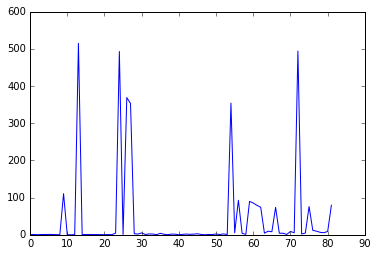

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3935
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 3936
reset:  current_state=1
choose_action: 0 randomly from state 1
step: y=0.0884, y_=-0.5064, next_state=2, reward=0.5948, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3937
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 3938
re

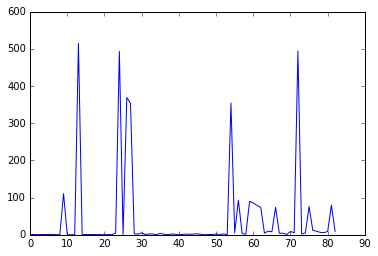

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4025
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4026
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4027
reset:  current_state=0
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4028
res

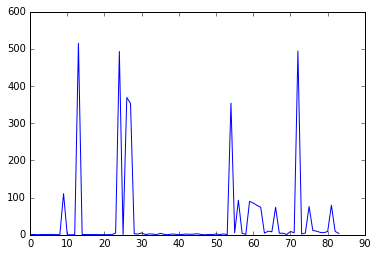

episode end at 0

episode: 4108
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4109
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4110
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4111
reset:  curr

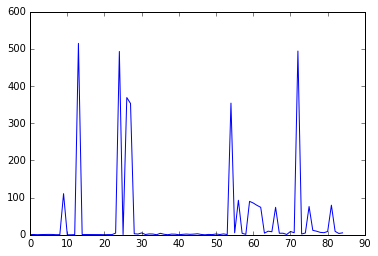

choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 randomly from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4199
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4200
reset:  current

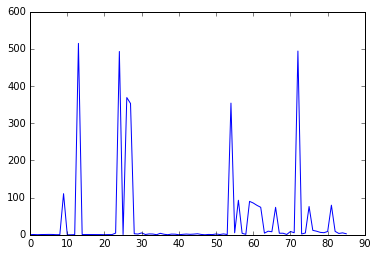

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4293
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4294
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4295
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4296
reset:  c

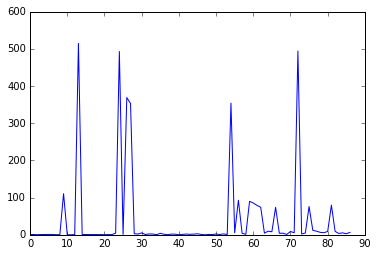

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 randomly from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4384
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4385
reset:  current_state=2
choose_action: 1 randomly from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1,

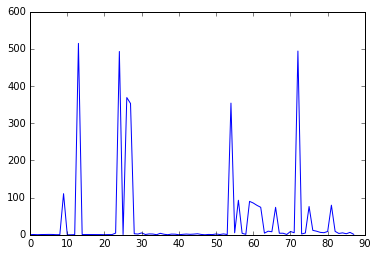

choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4475
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4476
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
epi

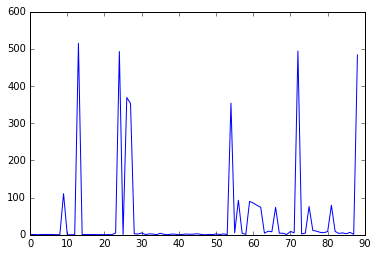

choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 randomly from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4568
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0

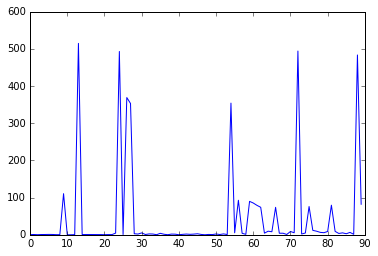

choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4658
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4659
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4660
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0

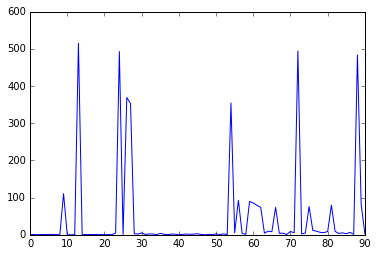

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4744
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4745
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
c

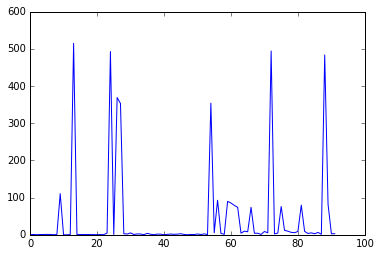

episode end at 0

episode: 4831
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4832
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4833
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 4834
reset:  current_state=6
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, r

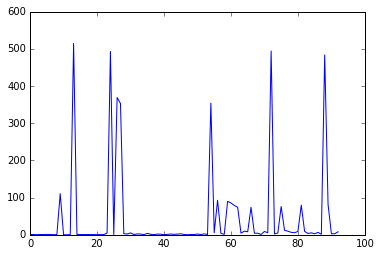

choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4922
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 4923
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=Fal

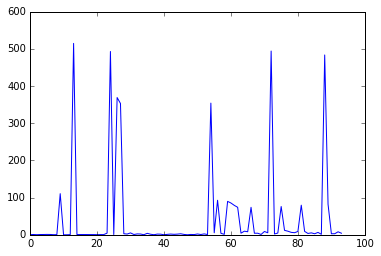

choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5011
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5012
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5013
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 randomly from s

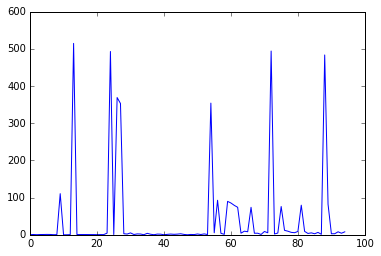

choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5102
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5103
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False


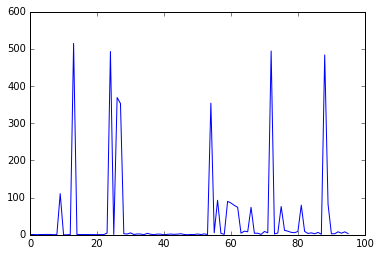

episode end at 0

episode: 5183
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5184
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5185
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step:

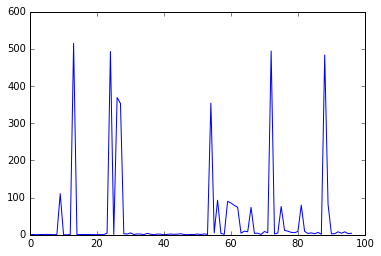

choose_action: 0 randomly from state 6
step: y=-0.1323, y_=0.4678, next_state=7, reward=-0.6001, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5277
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5278
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done

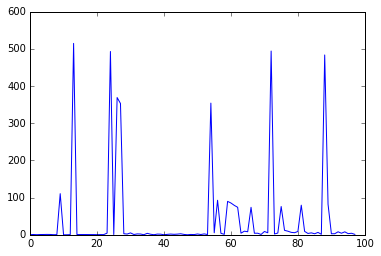

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5363
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5364
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=Tru

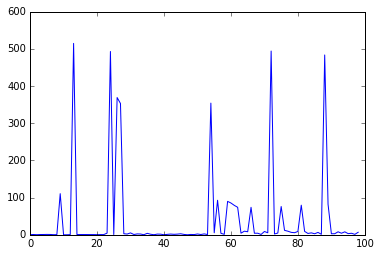

choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5456
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5457
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 0 randomly from state 0
step: y=0.6503, y_=0.0884, next_state=1, reward=0.5619, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5458
reset:  current_state=0
choose_action: 1 from state 0
step: y

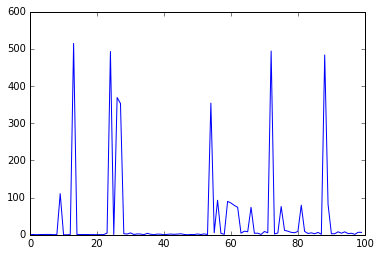

choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5544
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5545
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5546
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.

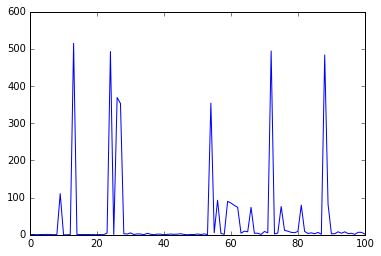

episode end at 4

episode: 5637
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5638
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5639
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5640
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 0 randomly from state 4
step: y=-0.9802, y_=-0.6832, next_state=5, r

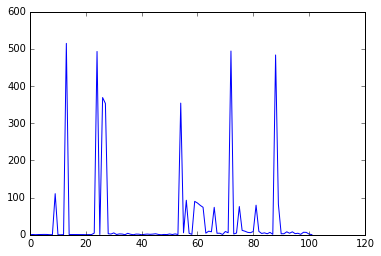

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 randomly from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5731
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5732
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, 

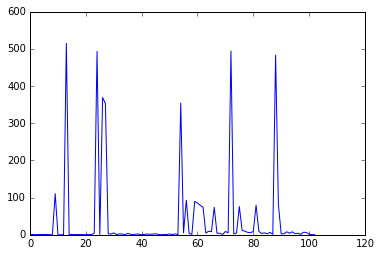

episode end at 4

episode: 5814
reset:  current_state=3
choose_action: 1 from state 3
step: y=-0.9130, y_=-0.5064, next_state=2, reward=-0.4066, done=False
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5815
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
ch

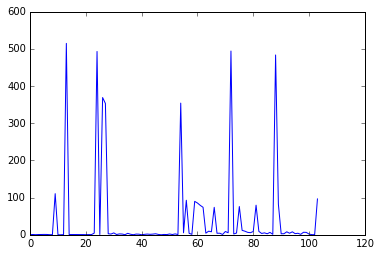

choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5898
reset:  current_state=0
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5899
reset:  current_state=1
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5900
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 5901
reset:  current_state=7
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.600

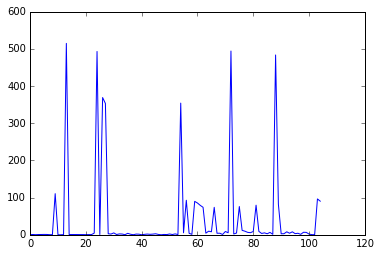

choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 5999
reset:  current_state=8
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6000
reset:  current_state=9
choose_action: 0 randomly from state 9
step: y=0.9880, y_=0.7148, next_state=10, reward=-27.3204, done=True
episode end at 9

episode: 6001
reset:  current_state=2
choose_action: 1 from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from sta

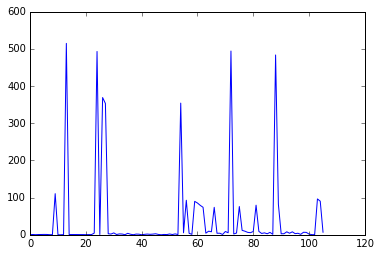

episode end at 0

episode: 6086
reset:  current_state=6
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6087
reset:  current_state=8
choose_action: 1 randomly from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6088
reset:  current_state=6
choose_action: 1

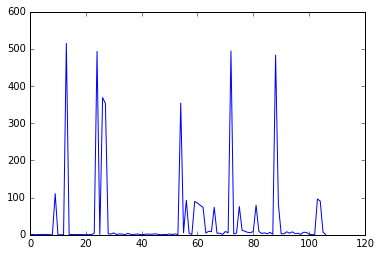

choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 randomly from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 randomly from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6174
reset:  current_state=5
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6175
reset:  current_state=7
choose_action: 0 randomly from state 7
step: y=0.4678, y_=0.8940, next_state=8, reward=-0.4262, done=False
choose_action: 0 randomly from state 8
step: y=0.8940, y_=0.9880, next_state=9, reward=-0.0940, done=False
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_s

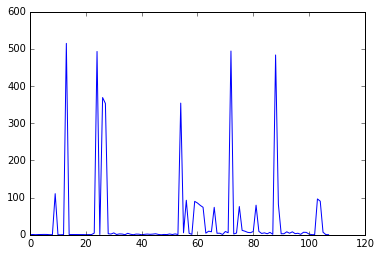

episode end at 4

episode: 6255
reset:  current_state=2
choose_action: 1 randomly from state 2
step: y=-0.5064, y_=0.0884, next_state=1, reward=-0.5948, done=False
choose_action: 1 from state 1
step: y=0.0884, y_=0.6503, next_state=0, reward=-0.5619, done=False
choose_action: 1 from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 6256
reset:  current_state=6
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward=0.2970, done=False
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6257
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6258
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, rewa

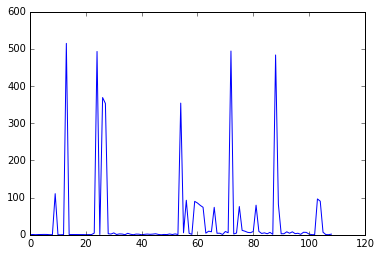

episode end at 4

episode: 6331
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6332
reset:  current_state=0
choose_action: 1 randomly from state 0
step: y=0.6503, y_=0.9705, next_state=-1, reward=-32.0247, done=True
episode end at 0

episode: 6333
reset:  current_state=4
choose_action: 1 from state 4
step: y=-0.9802, y_=-0.9130, next_state=3, reward=-3.3638, done=True
episode end at 4

episode: 6334
reset:  current_state=9
choose_action: 1 from state 9
step: y=0.9880, y_=0.8940, next_state=8, reward=0.0940, done=False
choose_action: 1 from state 8
step: y=0.8940, y_=0.4678, next_state=7, reward=0.4262, done=False
choose_action: 1 from state 7
step: y=0.4678, y_=-0.1323, next_state=6, reward=0.6001, done=False
choose_action: 1 from state 6
step: y=-0.1323, y_=-0.6832, next_state=5, reward=0.5509, done=False
choose_action: 1 from state 5
step: y=-0.6832, y_=-0.9802, next_state=4, reward

KeyboardInterrupt: 

In [10]:
#total_history = []
for i_episode in range(100000):
    #epi_history = []
    print('\nepisode: {}'.format(i_episode))
    s = env.reset()
    while True:
        x = [1 if i==s else 0 for i in range(N_STATES)]
        a = dqn.choose_action(x)
        #epi_history.append((s, a))

        # choose action and get reward from environment
        s_, r, done, info = env.step(a)
       
        # save memory
        x_ = [1 if i==s_ else 0 for i in range(N_STATES)]
        dqn.store_transition(x, a, r, x_)  #(s, a, r, s_)

        if dqn.memory_counter >  MEMORY_CAPACITY :
            dqn.learn() # if memory is full, learn
            dqn.plot_loss()

        if done:    
            print ("episode end at {}".format(s))
            break

        s = s_
    #total_history.append(epi_history)
